In [4]:
!git clone https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch.git
!mkdir data
!mv Facial-Similarity-with-Siamese-Networks-in-Pytorch/data/faces/testing/* data/
!mv Facial-Similarity-with-Siamese-Networks-in-Pytorch/data/faces/training/* data/

fatal: destination path 'Facial-Similarity-with-Siamese-Networks-in-Pytorch' already exists and is not an empty directory.
mkdir: cannot create directory ‘data’: File exists
mv: cannot stat 'Facial-Similarity-with-Siamese-Networks-in-Pytorch/data/faces/testing/*': No such file or directory
mv: cannot stat 'Facial-Similarity-with-Siamese-Networks-in-Pytorch/data/faces/training/*': No such file or directory


In [5]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from matplotlib import pyplot as plt
import glob
from sklearn.metrics import accuracy_score

from aijack.attack import MI_FACE
from aijack.defense import GeneralMomentAccountant, DPSGDManager
from aijack.utils import NumpyDataset

BASE = "data/"

In [6]:
imgs = []
labels = []
for i in range(1, 41):
    for j in range(1, 11):
        img = cv2.imread(BASE + f"s{i}/{j}.pgm", 0)
        imgs.append(img)
        labels.append(i - 1)

X = np.stack(imgs)
y = np.array(labels)


transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
trainset = NumpyDataset(X, y, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True, num_workers=2
)


iterators=4
reconstructor = []

for iter in range(iterators):

    if iter==0:
        class Net(nn.Module):
            def __init__(self):
                super(Net, self).__init__()
                self.fla = nn.Flatten()
                self.fc = nn.Linear(112 * 92, 40)

            def forward(self, x):
                x = self.fla(x)
                x = self.fc(x)
                x = F.softmax(x, dim=1)
                return x
            
    if iter==1:
        class Net(nn.Module):
            def __init__(self):
                super(Net, self).__init__()
                self.fla = nn.Flatten()
                self.fc = nn.Linear(112 * 92, 100)
                self.fc2= nn.Linear(100, 40)

            def forward(self, x):
                x = self.fla(x)
                x = self.fc(x)
                x= F.relu(x)
                x = self.fc2(x)
                x = F.softmax(x, dim=1)
                return x
            

    if iter==2:
        class Net(nn.Module):
            def __init__(self):
                super(Net, self).__init__()
                self.fla = nn.Flatten()
                self.fc = nn.Linear(112 * 92, 500)
                self.fc2= nn.Linear(500, 100)
                self.fc3= nn.Linear(100, 40)

            def forward(self, x):
                x = self.fla(x)
                x = self.fc(x)
                x= F.relu(x)
                x = self.fc2(x)
                x= F.relu(x)
                x = self.fc3(x)
                x = F.softmax(x, dim=1)
                return x
            
    if iter==3:
        class Net(nn.Module):
            def __init__(self):
                super(Net, self).__init__()
                self.fla = nn.Flatten()
                self.fc = nn.Linear(112 * 92, 1000)
                self.fc2= nn.Linear(1000, 500)
                self.fc3= nn.Linear(500, 100)
                self.fc4= nn.Linear(100, 40)

            def forward(self, x):
                x = self.fla(x)
                x = self.fc(x)
                x= F.relu(x)
                x = self.fc2(x)
                x= F.relu(x)
                x = self.fc3(x)
                x= F.relu(x)
                x = self.fc4(x)
                x = F.softmax(x, dim=1)
                return x


    net = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

    for epoch in range(100):  # loop over the dataset multiple times
        running_loss = 0
        data_size = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.to(torch.int64))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            data_size += inputs.shape[0]
            

    input_shape = (1, 1, 112, 92)
    target_label = 11
    lam = 0.03
    num_itr = 1000

    mi = MI_FACE(
        net,
        input_shape,
        target_label=target_label,
        num_itr=num_itr,
        lam=lam,
        log_interval=0,
    )
    x_result_1, log = mi.attack()
    reconstructor.append(x_result_1[0][0].detach().numpy())

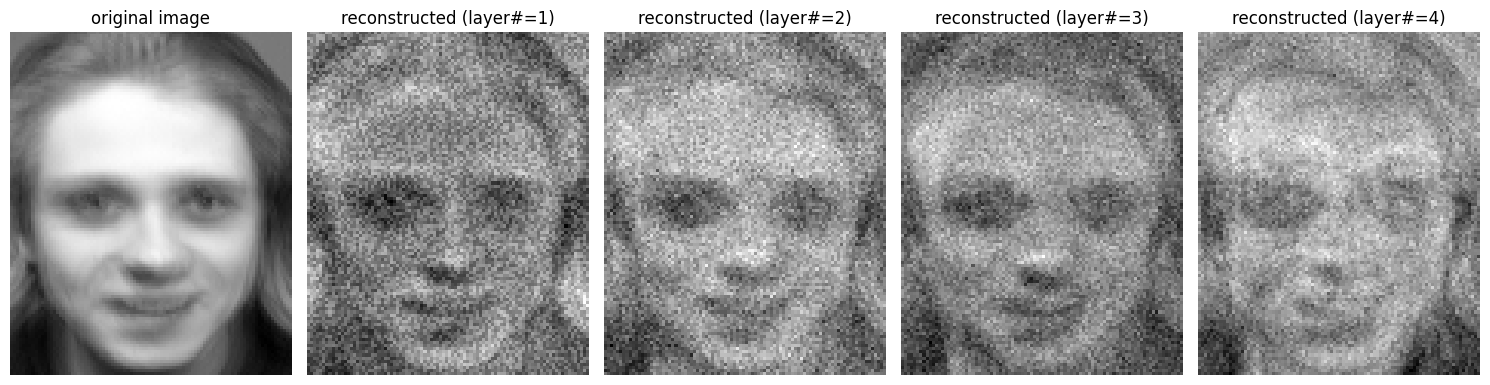

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=iterators+1, figsize=(15,15))
axes[0].imshow(
    np.mean([cv2.imread(p, 0) for p in glob.glob(BASE + "s12/*.pgm")], axis=0),
    cmap="gray",
)
axes[0].axis("off")
axes[0].set_title("original image")
for i in range(iterators):
    axes[i+1].imshow(reconstructor[i], cmap="gray")
    axes[i+1].axis("off")
    axes[i+1].set_title(f"reconstructed (layer#={i+1})")
plt.tight_layout()
plt.show()
